# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook:
1. Get probe template
2. Get the Bragg disks
3. **Calibrate**
4. Calculate lattice vectors
5. Refine lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 3: Calibrate

In this step the necessary calibrations are performed.  This includes:

1. Measuring and correcting the relative shifts of the diffraction patterns due to the scanning of the beam
2. Measuring and correcting elliptical distortion of the diffraction patterns
3. Measuring the detector pixel size

### Import packages, load data

In [179]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
from time import time
from scipy.ndimage.filters import gaussian_filter

from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.readwrite import FileBrowser, read, append

# i/o
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.readwrite import FileBrowser, read, append

# Diffraction shift correction
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.process.calibration import get_diffraction_shifts, find_outlier_shifts, shift_braggpeaks
from py4DSTEM.process.fit import fit_2D
from py4DSTEM.process.braggdiskdetection import get_deconvolution

# Elliptical distortion correction
from py4DSTEM.process.utils import radial_integral, get_maxima_1D
from py4DSTEM.process.calibration import measure_elliptical_distortion, correct_elliptical_distortion

In [180]:
# Examine file contents

#fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
fp = "/Users/Ben/Work/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    deconvolution_uncorrected           DiffractionSlice    
   2    probe                               DiffractionSlice    
   3    braggpeaks                          PointListArray      
   4    pointlistarray_0                    PointListArray      


In [181]:
# Load data

dc = browser.get_dataobject('datacube')
braggpeaks = browser.get_dataobject('braggpeaks')
average_deconvolution = browser.get_dataobject('deconvolution_uncorrected').data2D
browser.close()

### 1. Diffraction shifts

Here we measure and correct shifts of the diffraction patterns due to the scanning of the beam in real space.  We proceed as follows:

Measure diffraction shifts
- Get an initial guess at the diffraction shifts
- Find outliers in initial diffraction shift guesses
- Ignoring outliers, fit a plane or parabola to the initial guess.

Correct diffraction shifts
- Apply shifts to the Bragg peak positions

#### Measure diffraction shifts

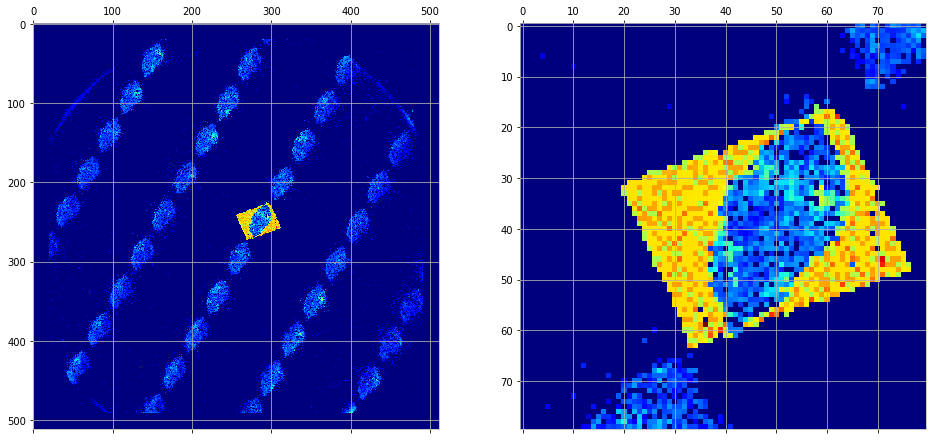

In [182]:
# Plot deconvolution

x0,y0=get_CoM(average_deconvolution)
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(average_deconvolution**0.25,cmap='jet')
ax2.matshow(average_deconvolution[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

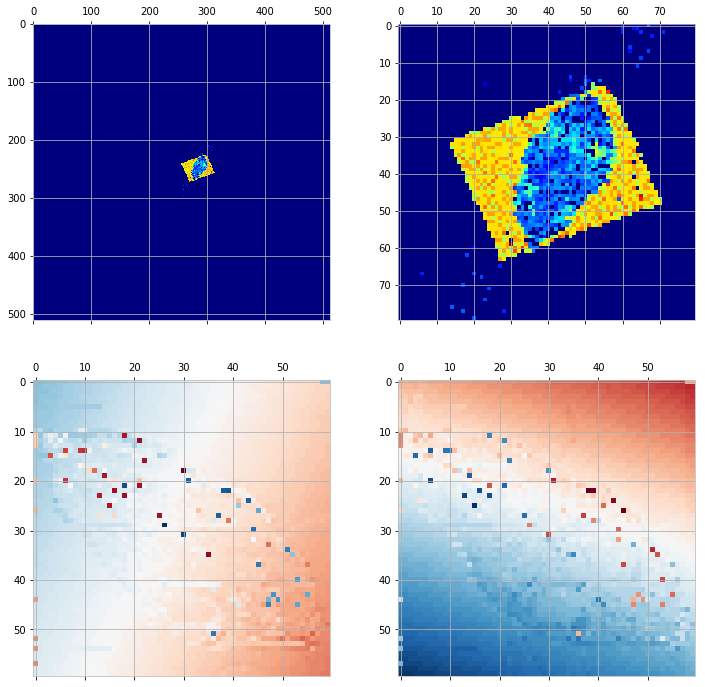

In [183]:
# Get diffraction shifts

findcenter = 'CoM'   # Must be 'CoM' or 'max'
rad = 40             # for display
power = 0.25

xshifts, yshifts, deconvolution_center = get_diffraction_shifts(braggpeaks,
                                                                dc.Q_Nx, dc.Q_Ny,
                                                                findcenter=findcenter)

# Show
x0,y0 = py4DSTEM.process.utils.get_CoM(deconvolution_center)

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(deconvolution_center**0.25,cmap='jet')
ax12.matshow(deconvolution_center[int(x0-rad):int(x0+rad),int(y0-rad):int(y0+rad)]**power,cmap='jet')
ax21.matshow(xshifts,cmap="RdBu")
ax22.matshow(yshifts,cmap="RdBu")
plt.show()

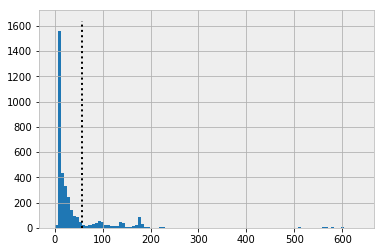

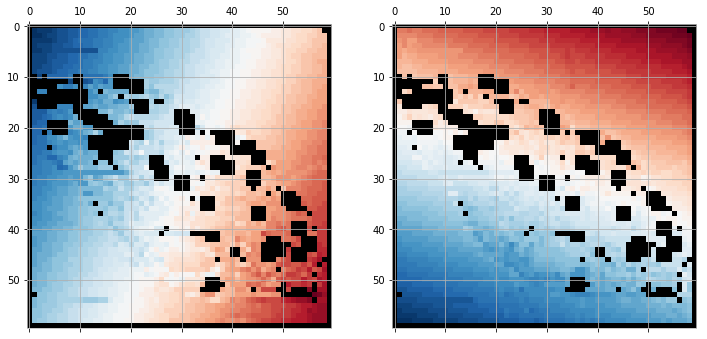

In [184]:
# Find outliers

n_sigma = 20
edge_boundary = 1
n_bins = 100

mask,n,bins,cutoff = find_outlier_shifts(xshifts,yshifts,n_sigma=n_sigma,edge_boundary=edge_boundary,n_bins=n_bins)

# Show
xshifts_masked = np.ma.masked_array(xshifts, mask)
yshifts_masked = np.ma.masked_array(yshifts, mask)
mask_display = np.ma.masked_array(mask, mask==False)

fig,ax = plt.subplots()
ax.bar(bins[:-1]+(bins[1]-bins[0])/2., n, (bins[1]-bins[0]), align='center')
ax.vlines(cutoff,0,ax.get_ylim()[1],linestyle=':')
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(xshifts_masked,cmap="RdBu")
ax2.matshow(yshifts_masked,cmap="RdBu")
ax1.matshow(mask_display)
ax2.matshow(mask_display)
plt.show()

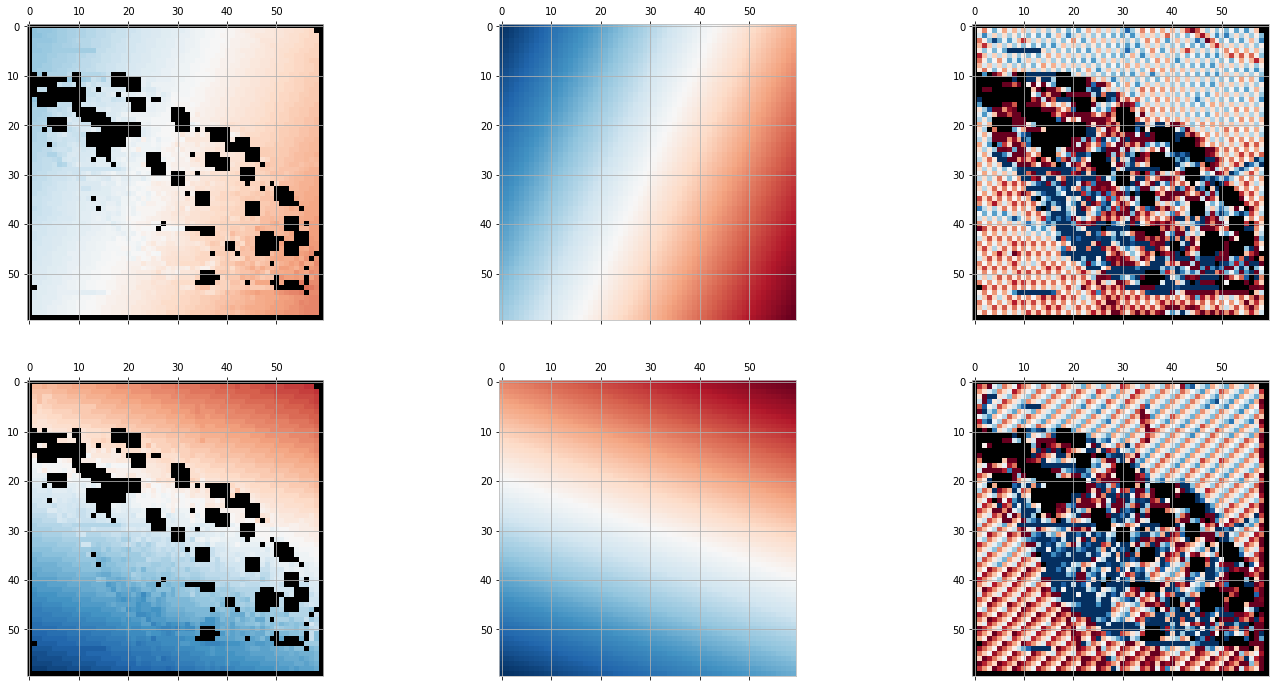

In [185]:
# Fit the diffraction shifts

fit_function = py4DSTEM.process.fit.plane        # Select fit type
#fit_function = py4DSTEM.process.fit.parabola

# Fit
xshifts_fit = np.zeros_like(xshifts)
yshifts_fit = np.zeros_like(yshifts)
popt_x, pcov_x, xshifts_fit = fit_2D(fit_function, xshifts, data_mask=mask==False)
popt_y, pcov_y, yshifts_fit = fit_2D(fit_function, yshifts, data_mask=mask==False)
residuals_x = xshifts-xshifts_fit
residuals_y = yshifts-yshifts_fit
residuals_x[mask] = 0
residuals_y[mask] = 0

# Show
fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,12))
ax11.matshow(xshifts,cmap="RdBu")
ax21.matshow(yshifts,cmap="RdBu")
ax12.matshow(xshifts_fit,cmap="RdBu")
ax22.matshow(yshifts_fit,cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu",vmin=np.median(residuals_x)-np.std(residuals_x),vmax=np.median(residuals_x)+np.std(residuals_x))
ax23.matshow(residuals_y,cmap="RdBu",vmin=np.median(residuals_y)-np.std(residuals_y),vmax=np.median(residuals_y)+np.std(residuals_y))
ax11.matshow(mask_display)
ax21.matshow(mask_display)
ax13.matshow(mask_display)
ax23.matshow(mask_display)
plt.show()

#### Correct diffraction shifts

In [186]:
# Apply shifts

shifted_braggpeaks = shift_braggpeaks(braggpeaks, xshifts_fit, yshifts_fit)

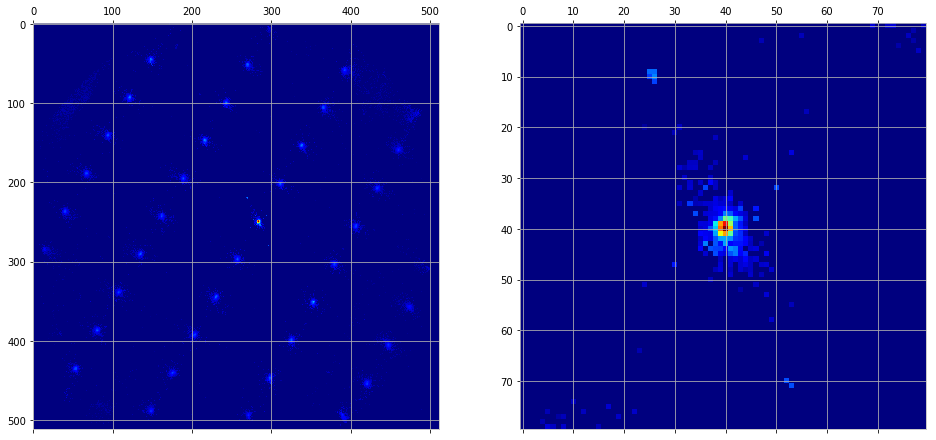

In [187]:
# Re-calculate average deconvolution and show

deconvolution = get_deconvolution(shifted_braggpeaks,dc.Q_Nx,dc.Q_Ny)
power = 0.25

# Show
x0,y0=np.unravel_index(np.argmax(gaussian_filter(deconvolution,2)),(dc.Q_Nx,dc.Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**0.25,cmap='jet')
ax2.matshow(deconvolution[x0-rad:x0+rad,y0-rad:y0+rad]**power,cmap='jet')
plt.show()

### 2. Elliptical distortion

Here we measure and correct elliptical distortion of the diffraction patterns due to imperfect electron optics.  We proceed as follows:

Measure elliptical distortion
- Get the unscattered beam position
- Specify an annular fitting region
- Fit an ellipse

Correct elliptical distortion
- Correct the Bragg peak positions

The relevant mathematics is found at the end of notebooks/module_demos/calibration/ellipticaldistortion_NoBeamStop.ipynb.

#### Measure elliptical distortion

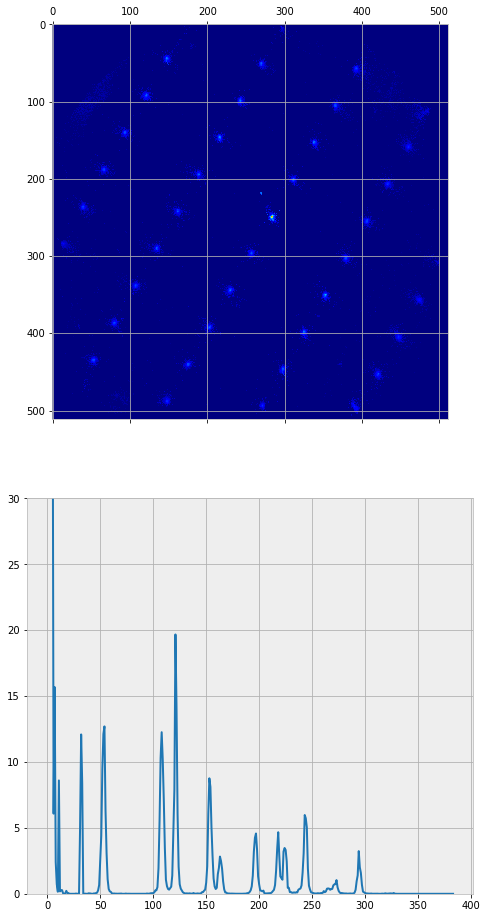

In [101]:
# Show deconvolution, calculate radial integral

ymax=30
power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution,2)),(dc.Q_Nx,dc.Q_Ny))
radial_profile = radial_integral(deconvolution,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(deconvolution**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

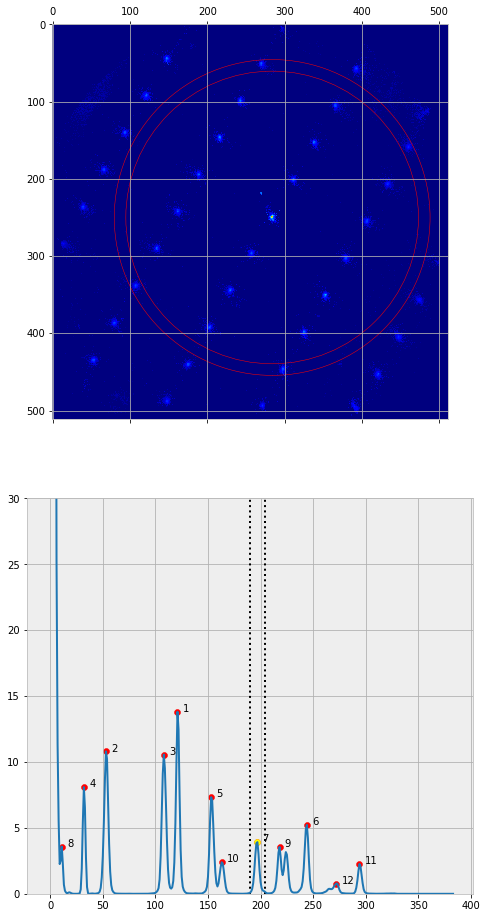

In [102]:
# Specify annular fitting region
# Get annulus center from selected radial profile maximum, specify annulus width

##### Parameters #####
# Find maxima
sigma = 1
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum and annulus width
selected_index = 7
annulus_width = 15

# Display params
ymax=30
text_offset = 5
power = 0.25
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(deconvolution**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

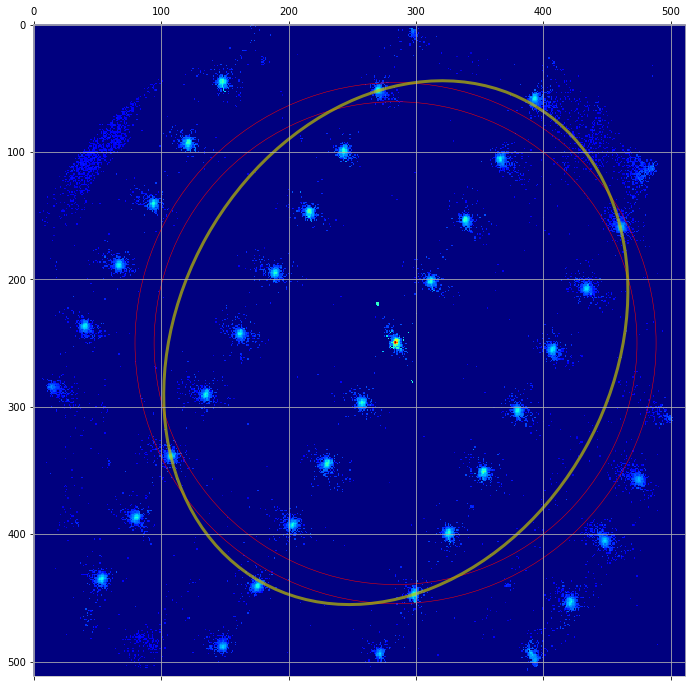

Measured elliptical distortion of 26.6%


In [105]:
# Measure elliptical distortion

power = 0.15

# Measure with no mask
ellipse_params,p1,xs,ys,vals = measure_elliptical_distortion(deconvolution, x0, y0, r_inner, r_outer)
x,y,a,b,theta = ellipse_params

# Measure with a mask
# mask = np.ones_like(deconvolution,dtype=bool)
# mask[:,int(y0-10):int(y0+10)] = False
# ellipse_params,_ = measure_elliptical_distortion(deconvolution, x0, y0, r_inner, r_outer, mask)
# x,y,a,b,theta = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(deconvolution**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y,x),2*a,2*b,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

print("Measured elliptical distortion of {:.3}%".format(100*(max(a,b)/min(a,b) - 1)))

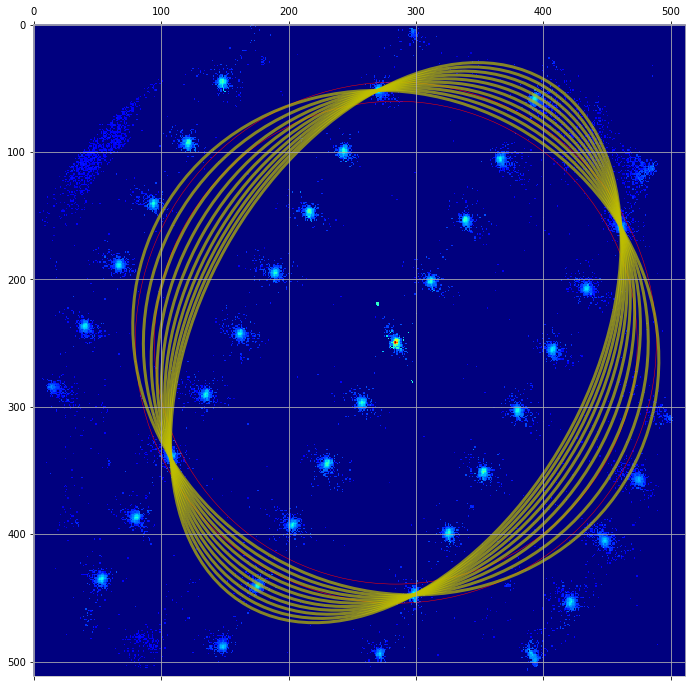

In [161]:
rad = 8
yy,xx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
rr = np.sqrt((xx-x)**2+(yy-y)**2)
mask = (rr>r_inner)*(rr<r_outer)
xd,yd = np.unravel_index(np.argmax(gaussian_filter(deconvolution*mask,2)),(dc.Q_Nx,dc.Q_Ny))
mask = (xx>xd-rad)*(xx<xd+rad)*(yy>yd-rad)*(yy<yd+rad)
xd,yd = get_CoM(deconvolution*mask)
xd,yd = xd-x,yd-y
T = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
xT,yT = np.matmul(T,np.array([xd,yd]))

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(deconvolution**power,cmap='jet')
circle_inner = Circle((y,x),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y,x),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
for t in np.linspace(0.9,1.1,10):
    at = a*t
    bt = np.sqrt(yT**2/(1-(xT/(at))**2))
    ellipse = Ellipse((y,x),2*at,2*bt,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
    ax.add_patch(ellipse)
plt.show()

In [227]:
def constrain_degenerate_ellipse(data, x, y, a, b, theta, r_inner, r_outer, phi_known, fitrad=6):
    # Get constraining point
    yy,xx = np.meshgrid(np.arange(data.shape[1]),np.arange(data.shape[0]))
    rr = np.sqrt((xx-x)**2+(yy-y)**2)
    mask = (rr>r_inner)*(rr<r_outer)
    x_fixed,y_fixed = np.unravel_index(np.argmax(gaussian_filter(data*mask,2)),(data.shape[0],data.shape[1]))
    rr = np.sqrt((xx-x_fixed)**2+(yy-y_fixed)**2)
    mask = rr<fitrad
    x_fixed,y_fixed = get_CoM(data*mask)

    # Transform constraining point to coordinate system orthogonal to semiaxis and with origin at ellipse center
    x_fixed,y_fixed = x_fixed-x,y_fixed-y
    T = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
    x_fixed,y_fixed = np.matmul(T,np.array([x_fixed,y_fixed]))
    
    # Get semiaxes a,b for the specified theta
    t = x_fixed/(a*np.cos(phi_known/2.))
    a_constrained = a*t
    b_constrained = np.sqrt(y_fixed**2/(1-(x_fixed/(a_constrained))**2))
    
    return a_constrained, b_constrained

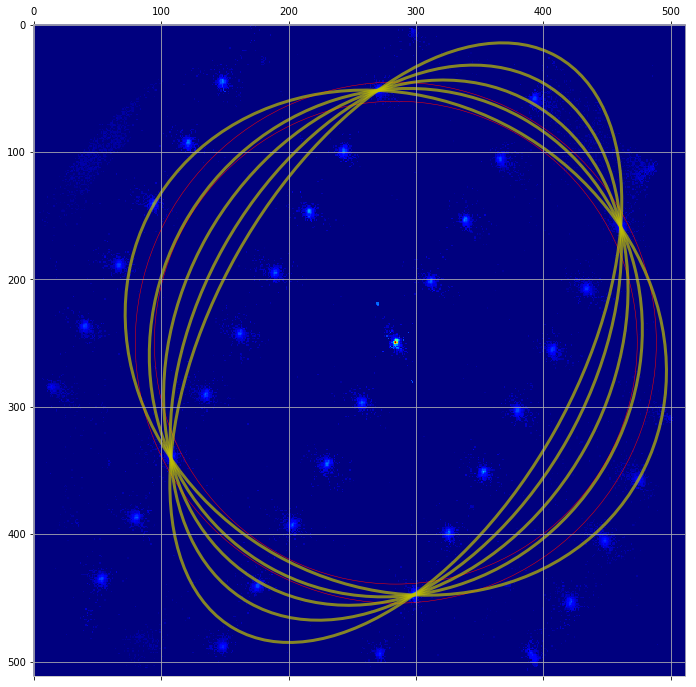

In [229]:
phi_vals = np.radians([60,70,80,90,100])
a_vals,b_vals = np.zeros_like(phi_vals),np.zeros_like(phi_vals)
for i in range(len(phi_vals)):
    phi = phi_vals[i]
    a_vals[i],b_vals[i] = constrain_degenerate_ellipse(deconvolution,x,y,a,b,theta,r_inner,r_outer,phi,fitrad=8)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(deconvolution**power,cmap='jet')
circle_inner = Circle((y,x),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y,x),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
for i in range(len(phi_vals)):
    ellipse = Ellipse((y,x),2*a_vals[i],2*b_vals[i],90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
    ax.add_patch(ellipse)
plt.show()

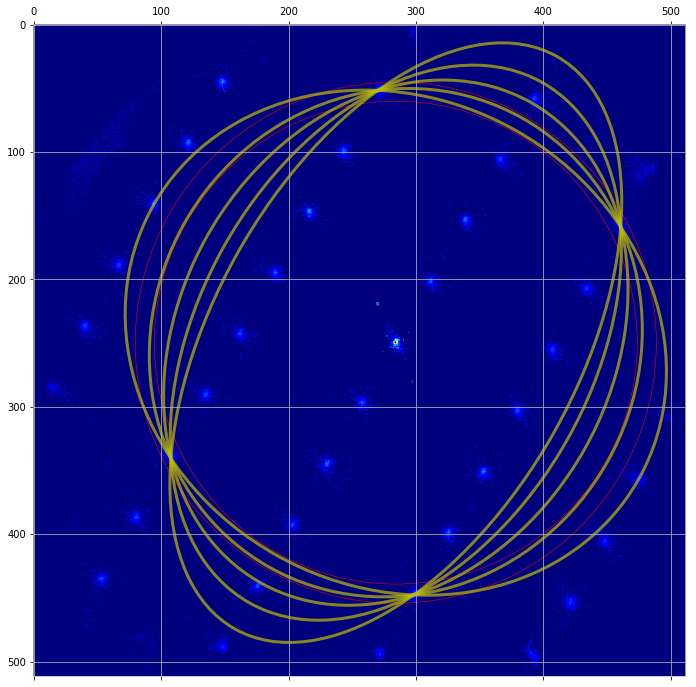

In [216]:
rad = 8
yy,xx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
rr = np.sqrt((xx-x)**2+(yy-y)**2)
mask = (rr>r_inner)*(rr<r_outer)
xd,yd = np.unravel_index(np.argmax(gaussian_filter(deconvolution*mask,2)),(dc.Q_Nx,dc.Q_Ny))
mask = (xx>xd-rad)*(xx<xd+rad)*(yy>yd-rad)*(yy<yd+rad)
xd,yd = get_CoM(deconvolution*mask)
xd,yd = xd-x,yd-y
T = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
xT,yT = np.matmul(T,np.array([xd,yd]))

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(deconvolution**power,cmap='jet')
circle_inner = Circle((y,x),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y,x),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
for final_halfangle_degrees in [30,35,40,45,50]:
    t = xT/(a*np.cos(np.radians(final_halfangle_degrees)))
    at = a*t
    bt = np.sqrt(yT**2/(1-(xT/(at))**2))
    ellipse = Ellipse((y,x),2*at,2*bt,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
    ax.add_patch(ellipse)
plt.show()

In [168]:
#Assume the final angle should be 20 degrees...

final_halfangle_deg = 40
t = xT/(a*np.cos(np.radians(final_halfangle_deg)))

In [169]:
t

1.003495606123937

In [135]:
xdc = xd*np.sin(theta)
ydc = yd*np.cos(theta)

In [136]:
np.sqrt(y0**2/(1-(x0/a)**2))

/Users/Ben/Code/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


nan

In [138]:
xdc**2/a**2 + ydc**2/b**2

0.20805918597530526

In [159]:
t=

at = a*t
bt = np.sqrt(yT**2/(1-(xT/(at))**2))

In [160]:
bt

135.58263580401683

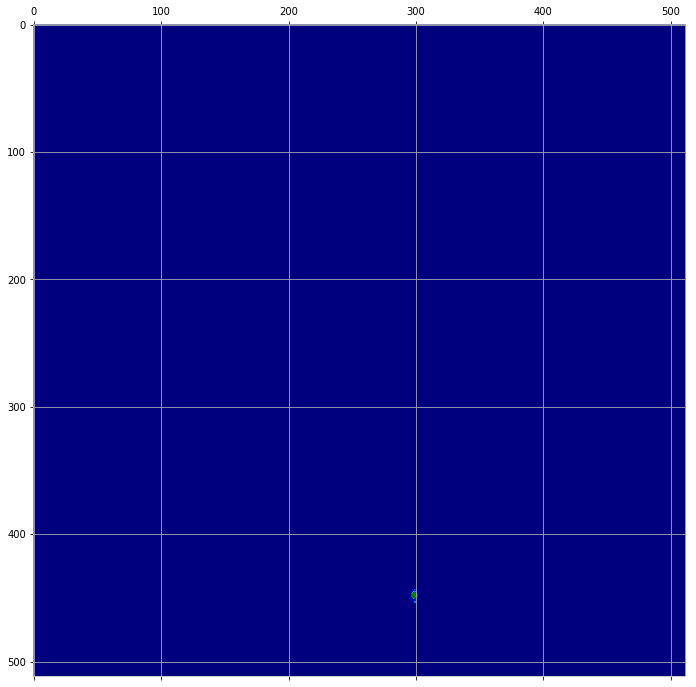

In [114]:
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(deconvolution*mask,cmap='jet')
ax.scatter(y+yd,x+xd,color='g')
plt.show()

In [107]:
t=1

at = a*t
bt = np.sqrt(yd**2/(1-(xd/(at))**2))

/Users/Ben/Code/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt


In [145]:
T = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
xT,yT = np.matmul(T,np.array([xd,yd]))
xT**2/a**2 + yT**2/b**2

1.0034707693666796

In [146]:
np.sqrt(yT**2/(1-(xT/(a))**2))

170.9526635625789

In [55]:
data=np.arange(99).reshape(33,3)

In [64]:
np.array([data[:,i] for i in range(3)],dtype)

array([[ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45,
        48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93,
        96],
       [ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46,
        49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94,
        97],
       [ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47,
        50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95,
        98]])

In [105]:
coords=[('qx',int),('qy','i8'),('inten',int)]
dtype = np.dtype(coords)

In [126]:
formats = ''
types=[field[1] for field in coords]
for i in range(len(types)):
    try:
        curr_type = types[i].__name__
    except AttributeError:
        curr_type = str(types[i])
    formats += '{},'.format(curr_type)

stuctarray = np.core.records.fromarrays(data.T, 
                                        names=dtype.names,
                                        #names=[field[0] for field in coords],
                                        formats = formats)

In [127]:
stuctarray['qy']

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
       52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97])

In [121]:
dtype.names

('qx', 'qy', 'inten')

In [120]:
str(dtype['qy'])

'int64'

In [101]:
int.__name__

'int'

In [103]:
a='i8'

a.__name__


AttributeError: 'str' object has no attribute '__name__'

### Save

In [18]:
# Append to processing file

dataobjects = [diffraction_shifts_fit, shifted_Braggpeak_pointlistarray, deconvolution]

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
append(dataobjects, fp)

Opening file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5...
Done.
